**Valentin Stanev**

**Machine Learning Superconductivity**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
plt.style.use('ggplot')

## Read and clean the data

Import the data using pandas and have a quick look with some basic functions: shape, head() , describe()

In [2]:
# !wget -O Supercond_ML_data.zip https://drive.google.com/u/0/uc?id=18Di08gG5749qXzOax-vzS3navEYRwL51&export=download
# !unzip Supercond_ML_data.zip

In [3]:
data = pd.read_csv('SC_short_June2017.csv')
data.head()

,id,name,Tc
0,1,Sn1Te1,NaN
1,2,Au0.22Te0.78,1.54
2,3,La1.92Sr0.08Cu1O4,24
3,4,Bi2Sr1.85Ba0.15Ca1Cu2Oz,83.5
4,5,B2Mg1,39.5


Check the format and the shape

In [4]:
data["Tc"][2], type(data["Tc"][2])

('24', str)

In [5]:
print("Shape of the data: ", data.shape)

Shape of the data:  (9999, 3)


There are invalid compositions and $T_c$ entries

We need to do some basic data cleaning 

In [6]:
data.loc[17]

id                     18
name    La1.9Ca1.1Cu2O6+Y
Tc                    NaN
Name: 17, dtype: object

In [7]:
data[data['name'].str.contains("Oy|oz|ox|\\+d|\\+x|\\+D|\\+X|\\+z|\\+y|-y|-z|=z|Fz|Ph|Nn|-d|-x", case = False)]

,id,name,Tc
3,4,Bi2Sr1.85Ba0.15Ca1Cu2Oz,83.5
10,11,Bi4Sr4Er2Cu4O16+Y,NaN
17,18,La1.9Ca1.1Cu2O6+Y,NaN
22,23,Y1Ba2Cu2.7Fe0.3IOZ,NaN
27,28,Hg1Ba2Ca4Cu5Oz,87
...,...,...,...
9974,9975,Pb0.5Cd0.5Sr2Ca0.5Y0.5Cu2O7-Z,65
9977,9978,Y1Ba2Cu3O7-Z,90.5
9981,9982,Y1Ba2Cu2.55Co0.45O7-z,NaN
9982,9983,Er2Ba4Cu7O15-Z,85


In [8]:
data = data.loc[~data['name'].str.contains("Oy|oz|ox|\\+d|\\+x|\\+D|\\+X|\\+z|\\+y|-y|-z|=z|Fz|Ph|Nn|-d|-x", case = False)]
data = data[~data['Tc'].str.contains("C|Re", case = False, na=False)]
data.shape

(7844, 3)

Convert $T_c$ values to numbers

In [9]:
data["Tc"]= data["Tc"].apply(lambda x:  float(x))

In [10]:
data.head()

,id,name,Tc
0,1,Sn1Te1,NaN
1,2,Au0.22Te0.78,1.54
2,3,La1.92Sr0.08Cu1O4,24.00
4,5,B2Mg1,39.50
5,6,Pu1Rh1Ga5,8.50


What to do with the NA values?

No $T_c$ - can we say $T_c$=0?

In [11]:
data = data.fillna(0)

Get quick descrition of the data

In [12]:
data['Tc'].describe()

count    7844.000000
mean       19.527631
std        36.792161
min         0.000000
25%         0.631500
50%         6.095000
75%        25.600000
max      2161.000000
Name: Tc, dtype: float64

Clear mistake: $T_c$ = 2161 K.
Remove this entry

In [13]:
data['Tc'].sort_values(ascending=False)[:10]
data.loc[228]
data = data.drop([228])
data['Tc'].describe()

count    7843.000000
mean       19.254588
std        27.730373
min         0.000000
25%         0.629000
50%         6.090000
75%        25.600000
max       135.800000
Name: Tc, dtype: float64

In [14]:
data["name"].describe()

count           7843
unique          6293
top       Y1Ba2Cu3O7
freq              50
Name: name, dtype: object

What to do with the multiple entries for a single compound?

Average the $T_c$ values, but only if std($T_c$)< 5 K. Otherwise, discard the compound.

In [15]:
# Find the compositions with std(T_c)>5
grouped = data.groupby("name").agg({'Tc' : np.std}).dropna()
index1 = grouped[grouped > 5].dropna().index
print("How many compounds have sdt > 5 K: ", len(index1))
del grouped

#Average the T_c for the rest
print("Remaining entries: ", data[~data['name'].isin(index1)].shape[0])
data = data[~data['name'].isin(index1)].groupby("name", as_index=False).agg(np.mean)
# del data["index"]

How many compounds have sdt > 5 K:  141
Remaining entries:  7135


In [16]:
data["name"].describe()

count               6152
unique              6152
top       Ag0.005Zn0.995
freq                   1
Name: name, dtype: object

Check for NaN

In [17]:
data.isna().values.any()
#data.isna().sum().sum()

False

## First look at the data

How many compounds have no $T_c$?

In [18]:
print("number of compounds without Tc:",(data['Tc']==0).sum())
print("number of compounds with Tc:",(~(data['Tc']==0)).sum())
data['Tc'][(data['Tc']>0)].describe()

number of compounds without Tc: 1423
number of compounds with Tc: 4729


count    4729.000000
mean       23.131778
std        28.507565
min         0.001000
25%         3.420000
50%         9.830000
75%        32.000000
max       135.800000
Name: Tc, dtype: float64

Pandas also have ploting functions.

Let's check the distribution of $T_s$'s

<AxesSubplot:>

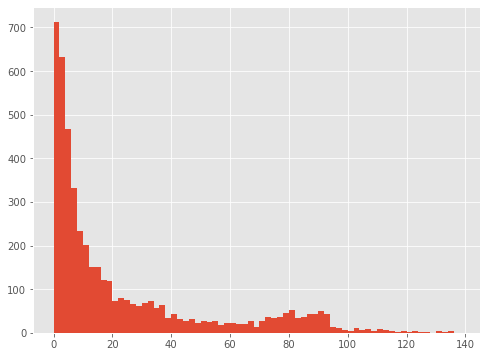

In [19]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 6.0)
data["Tc"][data["Tc"]>0].hist(bins = range(0,140, 2))

In [20]:
# Note the "iloc" (vs loc)!
data.iloc[data["Tc"].argsort().values[-10:]]

,name,id,Tc
2041,Hg1Ba2Ca1Cu2O6.21,7400.0,127.0
2003,Hg0.7Pb0.3Ba2Ca2Cu3O8.35,7529.0,130.0
2009,Hg0.8Bi0.2Ba2Ca2Cu3O8.2,4229.0,130.0
2006,Hg0.85Re0.15Ba1.6Sr0.4Ca2Cu3O8,887.0,130.3
1993,Hg0.6Ti0.4Ba2Ca2Cu3O8.4,3533.0,131.0
2005,Hg0.85Re0.15Ba1.66Sr0.34Ca2Cu3O8,9487.0,131.3
1995,Hg0.75Ba2.07Ca2.07Cu3.11O8.136,2440.0,132.9
2046,Hg1Ba2Ca2Cu3O8.29,6193.0,135.0
1996,Hg0.75Ba2.07Ca2.07Cu3.11O8.187,1229.0,135.4
1997,Hg0.75Ba2.07Ca2.07Cu3.11O8.208,7756.0,135.8


## Divide into groups

Check each compound name and divide into:

* Cuprates - contain Cu and O

- Fe-based - contain Fe and As/Se/Te/S/P

- Low-$T_c$ - everything else

In [21]:
data["Cuprate"] = data["name"].apply(lambda x: 1 if "Cu" in x and "O" in x else 0)
data["Fe-based"] = data["name"].apply(lambda x: 1 if ("Fe" in x and "As" in x) 
                                          or ("Fe" in x and "Se" in x)
                                          or ("Fe" in x and "S" in x)
                                          or ("Fe" in x and "Te" in x)
                                          or ("Fe" in x and "P" in x)
                                          else 0)
print("number of cuprates: " )
print((data["Cuprate"]==1).sum())
print("number of Fe-based: " )
print((data["Fe-based"]==1).sum())
print("number of others: " )
print(((data["Fe-based"]==0)&(data["Cuprate"]==0)).sum())
# (data["Cuprate"]==1).sum() + (data["Fe-based"]==1).sum() +((data["Fe-based"]==0)&(data["Cuprate"]==0)).sum()

number of cuprates: 
2067
number of Fe-based: 
616
number of others: 
3508


## Matminer

Need to generate predictors. Use Matminer - easily generates ~130 elemntal predictors

In [23]:
dataframe=data

In [24]:
dataframe

,name,id,Tc,Cuprate,Fe-based
0,Ag0.005Zn0.995,2473.0,0.763,0,0
1,Ag0.035Cd0.01Sn0.955,9686.0,3.650,0,0
2,Ag0.03Tl0.97,505.0,2.670,0,0
3,Ag0.04Cd0.784Cu0.01Zn0.166,1603.0,0.000,0,0
4,Ag0.12In0.88,7679.0,4.690,0,0
...,...,...,...,...,...
6147,Zr33.3V59.25Nb7.35,5034.0,6.300,0,0
6148,Zr3V3O1,143.0,7.500,0,0
6149,Zr46.75Ti8.25Cu7.5Ni10Be27.5,6165.0,1.840,0,0
6150,Zr54.6Ti23.4Ni22,634.0,2.780,0,0


In [25]:
#!pip install matminer

In [26]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.base import MultipleFeaturizer



In [27]:
dataframe=StrToComposition().featurize_dataframe(dataframe,'name',ignore_errors=True)


StrToComposition:   0%|          | 0/6152 [00:00<?, ?it/s]

In [28]:
# There are some NA entries in composition column of dataframe. We need to drop them for the next steps.
dataframe = dataframe[dataframe['composition'].notna()]

In [29]:
from matminer.featurizers import composition as cf
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

In [30]:
# Below step is not needed. So commenting out here.
#feature_labels = feature_calculators.feature_labels()


In [31]:

dataframe = feature_calculators.featurize_dataframe(dataframe, col_id='composition',ignore_errors=True);


MultipleFeaturizer:   0%|          | 0/6152 [00:00<?, ?it/s]

In [32]:
dataframe

,name,id,Tc,Cuprate,Fe-based,composition,0-norm,2-norm,3-norm,5-norm,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,Ag0.005Zn0.995,2473.0,0.763,0,0,"(Ag, Zn)",2,0.995013,0.995000,0.995000,...,194.155000,0.308450,194.0,1.995000,0.000000,10.000000,0.00,False,0.019409,0.000097
1,Ag0.035Cd0.01Sn0.955,9686.0,3.650,0,0,"(Ag, Cd, Sn)",3,0.955693,0.955016,0.955000,...,144.470000,6.627700,141.0,1.965000,1.910000,10.000000,0.00,False,0.018060,0.000185
2,Ag0.03Tl0.97,505.0,2.670,0,0,"(Ag, Tl)",2,0.970464,0.970010,0.970000,...,194.930000,1.804200,194.0,1.970000,0.970000,10.000000,13.58,False,0.023739,0.000691
3,Ag0.04Cd0.784Cu0.01Zn0.166,1603.0,0.000,0,0,"(Ag, Cd, Cu, Zn)",4,0.802441,0.786508,0.784067,...,195.550000,2.945000,194.0,1.950000,0.000000,10.000000,0.00,False,0.019409,0.000741
4,Ag0.12In0.88,7679.0,4.690,0,0,"(Ag, In)",2,0.888144,0.880743,0.880008,...,149.320000,18.163200,139.0,1.880000,0.880000,10.000000,0.00,False,0.005609,0.000592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6147,Zr33.3V59.25Nb7.35,5034.0,6.300,0,0,"(Zr, V, Nb)",3,0.684313,0.626635,0.599604,...,217.333333,15.555556,229.0,1.926426,0.000000,2.740240,0.00,False,0.022249,0.004851
6148,Zr3V3O1,143.0,7.500,0,0,"(Zr, V, O)",3,0.622700,0.543279,0.492502,...,183.000000,48.857143,194.0,2.000000,0.571429,2.142857,0.00,False,0.671436,0.079428
6149,Zr46.75Ti8.25Cu7.5Ni10Be27.5,6165.0,1.840,0,0,"(Zr, Ti, Cu, Ni, Be)",5,0.562683,0.499940,0.473971,...,199.425000,8.951250,194.0,1.925000,0.000000,2.650000,0.00,False,0.080661,0.010585
6150,Zr54.6Ti23.4Ni22,634.0,2.780,0,0,"(Zr, Ti, Ni)",3,0.633460,0.571064,0.548712,...,200.820000,10.639200,194.0,2.000000,0.000000,3.320000,0.00,False,0.080661,0.012822


In [33]:
feature_list = data.columns[5:]
feature_corr =  data[feature_list].corr().abs()

In [35]:
dataframe=dataframe.dropna()

In [36]:
dataframe.isna().values.any()

False

In [37]:
from matplotlib import cm as cm
cmap = cm.get_cmap("magma")
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(feature_corr, cmap=cmap)
plt.colorbar()
plt.show()

ZeroDivisionError: division by zero

In [40]:
dataframe.to_csv("cleaned_data.csv", index = False)